In [61]:
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import re 
import json 
import os
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms import ToTensor

psnr_metric = PeakSignalNoiseRatio(data_range=1.0)
lpips_metric = LearnedPerceptualImagePatchSimilarity
ssim_metric = structural_similarity_index_measure

renders_path = 'C:\Stuff\Dataset-creation\\renders_lego'
results_path = 'C:\Stuff\Dataset-creation\jsons_lego'

def add_text_to_image(input_image_path, output_image_path, text):
    image = Image.open(input_image_path)
    width, height = image.size
    draw = ImageDraw.Draw(image)
    font_size = 150
    font = ImageFont.truetype("arial.ttf", font_size)

    text_width, text_height = 200, 200
    x_position = width - text_width - 600
    y_position = height - text_height + 40

    text_color = (255, 0, 0)
    draw.text((x_position, y_position), text, font=font, fill=text_color)

    image.save(output_image_path)

In [66]:
for folder_path in os.listdir(renders_path)[:]:
    for filename in os.listdir(os.path.join(renders_path, folder_path)):
        if filename.lower().endswith('img.jpg') and 'crop' not in filename:
            file_path = os.path.join(renders_path, folder_path, filename)
            original_image = Image.open(file_path)
            original_width, original_height = original_image.size
            left = original_width / 2  # Start from the middle of the image to get the right half
            top = 0  # Start from the top edge of the image
            right = original_width  # Extend to the right edge of the image
            bottom = original_height  # Extend to the bottom edge of the image
            cropped_image = original_image.crop((left, top, right, bottom))
            new_filename = f"crop_degrated_{filename}"
            new_file_path = os.path.join(renders_path, folder_path, new_filename)
            cropped_image.save(new_file_path)
            original_image.close()

print("Cropping completed.")


Cropping completed.


In [63]:
psnrs, lpips_vals, ssims = [], [], []

# Helper function to load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return ToTensor()(image)

# List to store metrics for all runs
all_runs_metrics = []
for run_folder in os.listdir(renders_path)[:1]:
    run_path = os.path.join(renders_path, run_folder)
    if os.path.isdir(run_path):
        # Lists to store metrics for this run
        psnrs, lpips_vals, ssims = [], [], []

        # Loop over the images in the run directory
        for filename in os.listdir(run_path):
            if filename.endswith('img.jpg') and not filename.startswith('crop_degrated_'):
                base_name = filename.split('-')[0]
                degraded_filename = f'crop_degrated_{base_name}-img.jpg'
                degraded_filepath = os.path.join(run_path, degraded_filename)

                original_image_full = load_image(os.path.join(run_path, filename))
                # print(original_image_full.shape)
                original_width, original_height = original_image_full.shape[1], original_image_full.shape[2]
                original_image = original_image_full[:, :, :original_height // 2]
                # print(original_image.shape)
                # break
                # print(original_image)
                degraded_image = load_image(degraded_filepath)
                original_image = original_image.unsqueeze(0)  # Add batch dimension
                degraded_image = degraded_image.unsqueeze(0)  # Add batch dimension
                psnr = psnr_metric(original_image, degraded_image)
                ssim = ssim_metric(original_image, degraded_image)
                # Replace with actual LPIPS computation
                # lpips = torch.tensor(0)  # Placeholder, replace with actual LPIPS computation
                psnrs.append(psnr.item())
                ssims.append(ssim.item())
                # lpips_vals.append(lpips.item())

        # Append metrics for this run to the all runs list
        all_runs_metrics.append({
            'run': run_folder,
            'PSNR': psnrs,
            'SSIM': ssims,
            'LPIPS': lpips_vals
        })

# Now you have all the metrics for each run stored in all_runs_metrics
# You can print them, or save them to a file
for run_metrics in all_runs_metrics:
    print(f"Metrics for run {run_metrics['run']}:")
    print("PSNR values:", run_metrics['PSNR'])
    print("SSIM values:", run_metrics['SSIM'])
    print("LPIPS values:", run_metrics['LPIPS'])
    print("\n")

c:\Users\danko\miniconda3\envs\nerfstudio\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Metrics for run 2024-02-19_061424:
PSNR values: [15.671610832214355, 13.967564582824707, 15.505934715270996, 10.901954650878906, 12.133748054504395, 12.125770568847656, 11.851130485534668, 15.867193222045898, 15.94489860534668, 15.568641662597656, 15.362281799316406, 14.08130168914795, 11.886969566345215, 11.63809871673584, 15.51648235321045, 15.70478630065918, 15.86490535736084, 15.331969261169434, 14.513578414916992, 10.236783027648926, 11.34211540222168, 12.305542945861816, 14.691863059997559, 12.51229190826416, 11.83339786529541, 12.198790550231934, 15.653366088867188, 12.503904342651367, 12.513473510742188, 15.64819622039795, 15.701213836669922, 12.011804580688477, 10.560688018798828, 14.697198867797852, 15.985779762268066, 15.839517593383789, 11.492314338684082, 14.986947059631348, 15.848198890686035, 16.207582473754883, 11.986318588256836, 11.057600975036621, 15.880988121032715, 15.384400367736816, 9.564465522766113, 15.61352825164795, 12.23069953918457, 12.194009780883789, 12.1

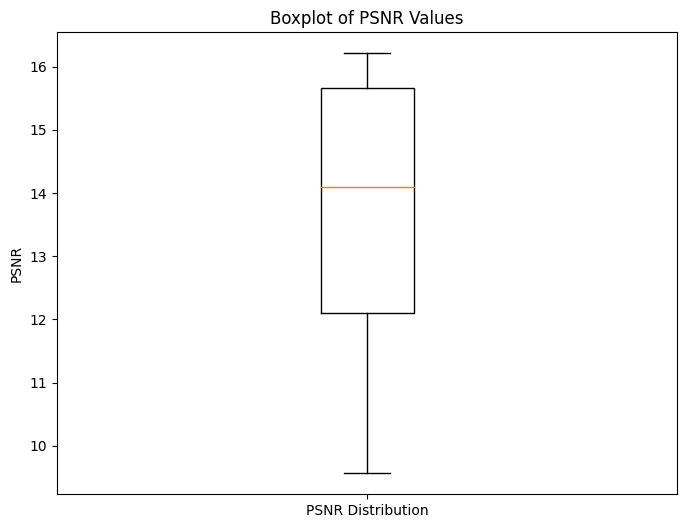

<module 'matplotlib.pyplot' from 'c:\\Users\\danko\\miniconda3\\envs\\nerfstudio\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy array of PSNR values, replace with your actual data
psnr_values = np.random.normal(loc=30, scale=5, size=100)

# Create a boxplot for the PSNR values
plt.figure(figsize=(8, 6))
plt.boxplot(run_metrics['PSNR'])
plt.title('Boxplot of PSNR Values')
plt.ylabel('PSNR')
plt.xticks([1], ['PSNR Distribution'])
plt.show()
plt


In [67]:
current_path = os.getcwd()

for file in os.listdir(results_path):
    f = open(os.path.join(results_path, file))
    data =  json.load(f)
    psnr = "{:.1f}".format(data['results']['psnr'])
    ckpt_path = data['checkpoint']
    pattern = r'\d{4}-\d{2}-\d{2}_\d{6}'
    match = re.search(pattern, ckpt_path)
    timestamp = match.group()
    
    if timestamp in os.listdir(renders_path):
        folder_with_images = os.path.join(renders_path, timestamp)
        for img in os.listdir(folder_with_images):
            if 'degrated' in img and 'psnr' not in img:
                input_image_path = os.path.join(folder_with_images, img)
                new_img_name = f'psnr-{img}' 
                output_image_path = f"{os.path.join(folder_with_images, new_img_name)}"
                text_to_add = f"PSNR: {psnr}"
                add_text_to_image(input_image_path, output_image_path, text_to_add)
            


In [68]:
import re 
from pathlib import Path
import json 
import os 

for file in os.listdir(results_path):
    f = open(os.path.join(results_path, file))
    data =  json.load(f)
    ckpt_path = data['checkpoint']
    pattern = r'\d{4}-\d{2}-\d{2}_\d{6}'
    match = re.search(pattern, ckpt_path)
    timestamp = match.group()
    
    if timestamp in os.listdir(renders_path):
        folder_with_images = os.path.join(renders_path, timestamp)
        for img in os.listdir(folder_with_images):
            if 'psnr' in img:
                input_image_path = os.path.join(folder_with_images, img)
                new_img_name = f'{file.replace(".json", "")}-{img}' 
                output_image_path = f"{os.path.join(folder_with_images, new_img_name)}"
                try: 
                    os.rename(input_image_path, output_image_path)
                except:
                    continue


In [71]:
import os
import shutil

def copy_images_with_psnr(source_folder, destination_folder):
    try:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        for root, dirs, files in os.walk(source_folder):
            for file in files:
                if 'psnr' in file and ('000001' in file) :
                    source_path = os.path.join(root, file)
                    destination_path = os.path.join(destination_folder, file)

                    shutil.copy2(source_path, destination_path)
                    print(f"Copied '{file}' to '{destination_folder}'.")

    except Exception as e:
        print(f"An error occurred: {e}")

destination_folder = 'C:\Stuff\Dataset-creation\\rendered_images_for_latex_lego'

copy_images_with_psnr(renders_path, destination_folder)



Copied 'lego-noise-std-112-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-128-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-16-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-32-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-48-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-64-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-80-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied 'lego-noise-std-96-psnr-crop_degrated_000001-img.jpg' to 'C:\Stuff\Dataset-creation\rendered_images_for_latex_lego'.
Copied

In [2]:
import os
from PIL import Image
'''
get rendered image of predicted scene in full size.
'''

renders_path = 'C:\Stuff\Dataset-creation\\renders'

# Iterate through files in the folder
for folder_path in os.listdir(renders_path)[:]:
    for filename in os.listdir(os.path.join(renders_path, folder_path)):
        if filename.lower().endswith('img.jpg') and 'crop' not in filename:
            file_path = os.path.join(renders_path, folder_path, filename)
            original_image = Image.open(file_path)
            original_width, original_height = original_image.size
            left = original_width/2
            top = 0
            right = original_width
            bottom = original_height 

            # Crop the image
            cropped_image = original_image.crop((left, top, right, bottom))
            new_filename = f"full_rendered_image_{filename}"
            new_file_path = os.path.join(renders_path, folder_path, new_filename)
            cropped_image.save(new_file_path)
            original_image.close()
            cropped_image.close()

print("Cropping completed.")


Cropping completed.
